Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# Multilayer Perceptrons

In the following we're going to train MLPs.  We'll start with a modest data set that has a half dozen features, and that we'll train a MLP to predict a binary target variable.  Then we'll train MLPs to predict the labels on digit images that is widely used to test a variety of predictive algorithms.  Both are larger datasets.  NNs have a voracious appetite for data.

We'll use the packages [Tensorflow](http://tensorflow.org) and [Keras](https://keras.io/), the latter being well integrated into the former in recent version releases. See [Keras in Tensorflow](https://www.tensorflow.org/beta/guide/keras).

# NN  Parameters

There are many parameters to set, and to "tweak" to try to improve performance.  They include:

* Learning rate:  this is the "step size" adjustment taken to update the values of weights upon evaluation of the gradient. 
* Optimizer selection: there are several available.
    * For a summary of those available in Tensorflow, see [Tensorflow Optimizers](https://www.tutorialspoint.com/tensorflow/tensorflow_optimizers).
* Number of layers.
* Number of nodes per layer.
* Activation function(s).
* Number of epochs: an epoch is a single forward pass and backward pass over the training examples.
* Batch size: the number of training examples in an epoch. (Sometimes called a _mini-batch_ to make it clear that the training examples in an epoch may not be the entire set of htem.)

If you have 5,000 training examples, and your batch size is 100, an epoch will require fifty (50) iterations.

It may be the case that, ceteris paribus, smaller batches will result in better generalization than larger ones. See [On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima](https://arxiv.org/abs/1609.04836).

# Getting Packages

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Markdown
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import linear_model
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
%matplotlib inline


# Mammography Data: Input and Munging

In [128]:
mammogram = pd.read_csv('DATA/ML/mammography.csv')
mammogram.columns
mammogram.describe()
mammogram['class'].value_counts()

Index(['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6', 'class'], dtype='object')

,attr1,attr2,attr3,attr4,attr5,attr6
count,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04
mean,1.096535e-10,1.297595e-09,5.698113e-10,-2.435705e-09,-1.120680e-09,1.459483e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
25%,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
50%,-1.085769e-01,-3.949941e-01,-2.309790e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
75%,3.139489e-01,-7.649473e-02,2.198366e-01,8.202077e-01,-3.778657e-01,1.016613e+00
max,3.150844e+01,5.085849e+00,2.947777e+01,9.591164e+00,2.361712e+01,1.949027e+00


'-1'    10923
'1'       260
Name: class, dtype: int64

_class_ is the target variable.  Its two categories are labeled as '-1' and '1'.  Let's create a new target by coded 0 and 1, and then we'll drop _class_. 

In [3]:
mammogram['target']=mammogram['class'].replace({"'-1'":0,"'1'":1})
mammogram.target.value_counts()
mammogram2=mammogram.drop('class',axis=1)
mammogram2.columns

0    10923
1      260
Name: target, dtype: int64

Index(['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6', 'target'], dtype='object')

In [4]:
## Create numpy arrays

X=mammogram.iloc[:,:6].to_numpy()  # features
y=pd.get_dummies(mammogram.target)
# y.sum(axis=0)
y=y.to_numpy()   # target

# Training, Test, and Validation Splits 

We'll use 80% of the data for training and testing, and the remaining 20% for final validation of the model.

In [5]:
np.random.seed(99)

In [6]:
stratSplit=StratifiedShuffleSplit(
        n_splits=1,
        test_size=0.40,
        random_state=99
        )
for trainNdx,testNdx in stratSplit.split(X,y):
    X_train=X[trainNdx]
    y_train=y[trainNdx]
    X_test0=X[testNdx]
    y_test0=y[testNdx]
    


In [7]:
stratSplit=StratifiedShuffleSplit(
        n_splits=1,
        test_size=0.50,
        random_state=99
            )
for valNdx, testNdx in stratSplit.split(X_test0,y_test0):
        X_valid=X_test0[valNdx]
        y_valid=y_test0[valNdx]
        X_test=X_test0[testNdx]
        y_test=y_test0[testNdx]


# MLP with Tensorflow and Keras 

We'll being with training a single hidden layer feedforward NLP that predicts our target variable using the six features attr1 through attr6 as inputs.

A "Sequential" Keras model is just a "stack" of layers connected sequentially.

## Network Specification

In [77]:
# You can use the following to reset the graph, or to wipe it out completely.
keras.backend.clear_session()  # this resets
 #del(mlp)                       # this deletes the graph

In [78]:

mlp = keras.models.Sequential() #stacked layers 
mlp.add(keras.layers.Dense(4,activation='relu',input_shape=(6,))) # six features per row in X
mlp.add(keras.layers.Dense(2,activation="softmax"))  # output layer: two categories, normalized to get probs

In [79]:
# Verifying the layers
mlp.layers 

In [80]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 28        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


In [81]:
## compile the network

mlp.compile(loss='categorical_crossentropy',
           optimizer='sgd',
           metrics=['accuracy'])


_sdg_, above is "stochastic gradient descent."

Keras provides a number of predefined loss functions.  See:

[Keras Loss Functions](https://keras.io/losses/)

Metrics:

[Keras metrics](https://keras.io/metrics/)

## Training

Output epoch by epoch is surpressed by _verbose_=0.

In [82]:
mlpTraining=mlp.fit(X_train,y_train,epochs=50,verbose=0,
                   validation_data=(X_test,y_test))

## Training By Epoch

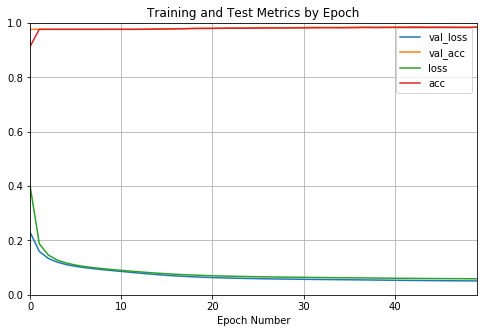

In [83]:
historyDF=pd.DataFrame(mlp.history.history)
historyDF.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Training and Test Metrics by Epoch")
plt.xlabel('Epoch Number')
plt.show();

It looks like training had "converged" by about half way through the epochs.  _But do you see anything odd?_

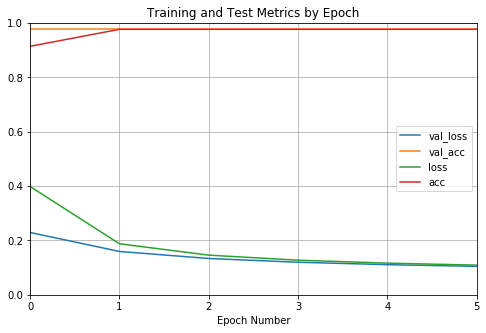

In [84]:
historyDF=pd.DataFrame(mlp.history.history).iloc[:6,:]
historyDF.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Training and Test Metrics by Epoch")
plt.xlabel('Epoch Number')
plt.show();

Note that the training and test metrics are not computed at the same time.  The training metrics are computed during an epoch.  The test metrics are computed at the _end_ of an epoch.  So the training measures should be shifted to the left w.r.t. the test metrics.

## Evaluation

Loss and accuracy on the test data.

In [85]:
testEval=mlp.evaluate(X_test,y_test,verbose=0)
print("Test Data: loss {:1.3f} accuracy {:1.3f}".format(testEval[0],testEval[1]))

Test Data: loss 0.051 accuracy 0.985


Loss and accuracy on the _validation_ data.

In [86]:
valEval=mlp.evaluate(X_valid,y_valid,verbose=0)
print("Validation Data: loss {:1.3f} accuracy {:1.3f}".format(valEval[0],valEval[1]))

Validation Data: loss 0.064 accuracy 0.983


## Prediction

This is done pretty much like with scikit-learn methods.

Let's predict using the validation data.

In [87]:
y_pred=mlp.predict_classes(X_valid)
pd.Series(y_pred).value_counts()

0    2218
1      19
dtype: int64

## Confusion!

In [88]:
confusion_matrix(y_valid[:,1],y_pred)

array([[2182,    3],
       [  36,   16]])

## Classification Summary

In [89]:
print("Classification Summary Based on Validation Data\n")
print(classification_report(y_valid[:,1],y_pred))

Classification Summary Based on Validation Data

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2185
           1       0.84      0.31      0.45        52

    accuracy                           0.98      2237
   macro avg       0.91      0.65      0.72      2237
weighted avg       0.98      0.98      0.98      2237



## Predicted Probabilities

In [90]:
y_predProb=mlp.predict_proba(X_valid)
pd.Series(y_predProb[:,1]).describe()

count    2.237000e+03
mean     2.316242e-02
std      8.215000e-02
min      5.236859e-11
25%      1.275275e-03
50%      4.671413e-03
75%      1.382906e-02
max      9.945709e-01
dtype: float64

In [91]:
y_valid.shape
y_predProb.shape

(2237, 2)

(2237, 2)

## ROC, AUC 

Note that "skplt.metrics.plot_roc()" expects a _matrix_ of predicted probabilities, one col per class.

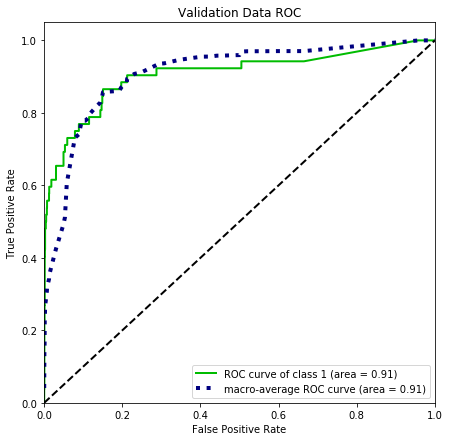

In [92]:
skplt.metrics.plot_roc(y_valid[:,1], y_predProb, title="Validation Data ROC",
                      figsize=(7,7),
                      plot_micro=False,
                      classes_to_plot=1)
plt.show();

## Unbalanced Target Labels

You can see that this MLP has difficulty with unbalanced labels. Here's something to try;

# A UDU: Train the MLP By Weighting Observations

One of the ways that can help training on data like this is to weight observations' contributions to the loss function based on how frequent, or infrequent, they are.  The Keras [fit function](https://keras.io/models/model/#fit) has an option _class weight_ that can be defined by a dict that maps weights to cases.  It should look something like {0:wt0, 1:wt1}, where wt0 and wt1 are weights (float) to be used for labels 0 and 1, respectively. See if you can apply this kind of weighting of the loss function when retraining the MLP, above.

One question is, what data should be used to calculate the weights?

# Another UDU: See If you Can Improve the MLP 

Can you improve the MLP, above, by adding layers to it?  By changing the number of nodes per layer? By using different learning rates? Using different activation functions?

# Regularization by "Dropout"

Several different methods for regularizing neural networks can be used. One of them consists of randomly removing, "or dropping out," individual neurons during training.  This effectively sets the outputs of these neurons doing an training iteration.  It's thought that doing this causes neurons to be less specialized.

Let's try applying drop-out to a hidden layer of a version of the MLP that's above, A two hidden layer MLP.  The drop-out will be between the 1<sup>st</sup> and the 2<sup>nd</sup> hidden layers.

## 3L Network Specification With Dropout, p(Dropout=0.20)

In [107]:
# del mlp2
keras.backend.clear_session()  # this resets
mlp2 = keras.models.Sequential() #stacked layers 
mlp2.add(keras.layers.Dense(6,activation='relu',input_shape=(6,))) # six features per row in X
mlp2.add(keras.layers.Dropout(0.2))
mlp2.add(keras.layers.Dense(4,activation='relu'))
mlp2.add(keras.layers.Dense(2,activation="softmax"))  # output layer: two categories, normalized to get probs

In [103]:
mlp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


## Compiling

In [108]:
mlp2.compile(loss='categorical_crossentropy',
           optimizer='sgd',
           metrics=['accuracy'])


## Training

In [109]:
mlp2Training=mlp2.fit(X_train,y_train,epochs=50,verbose=0,
                   validation_data=(X_test,y_test))

## Evaluation Using Validation Data

In [110]:
valEval2=mlp2.evaluate(X_valid,y_valid,verbose=0)
print("Validation Data: loss {:1.3f} accuracy {:1.3f}".format(valEval2[0],valEval2[1]))

Validation Data: loss 0.068 accuracy 0.980


## Confusion Again!

In [111]:
y_pred2=mlp2.predict_classes(X_valid)
pd.Series(y_pred2).value_counts()

0    2225
1      12
dtype: int64

In [112]:
confusion_matrix(y_valid[:,1],y_pred2)

array([[2183,    2],
       [  42,   10]])

In [113]:
print("Classification Summary Based on Validation Data\n")
print(classification_report(y_valid[:,1],y_pred2))

Classification Summary Based on Validation Data

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2185
           1       0.83      0.19      0.31        52

    accuracy                           0.98      2237
   macro avg       0.91      0.60      0.65      2237
weighted avg       0.98      0.98      0.97      2237



## Predicted Probabilities

In [114]:
# predicted probabilities
y_predProb2=mlp2.predict_proba(X_valid)

## ROC, AUC

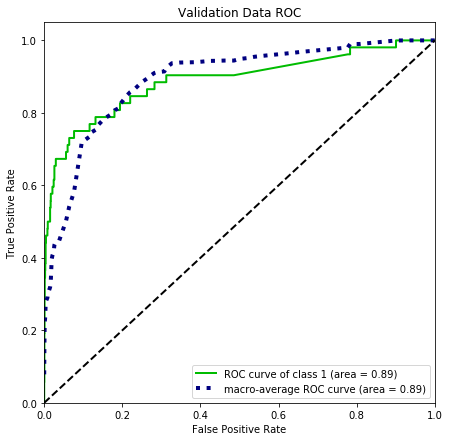

In [115]:
skplt.metrics.plot_roc(y_valid[:,1], y_predProb2, title="Validation Data ROC",
                      figsize=(7,7),
                      plot_micro=False,
                      classes_to_plot=1)
plt.show();

# "Tweaking" Dropout Regularization

* Dropout can be applied to input layers.
* It will be more beneficial when applied to larger, rather than smaller, networks.
* Dropout rates that are smaller, e.g. < 0.50, will tend to provide more benefit.

## UDU:  Try Additional Dropouts

See if you can bump up the AUC of the above.

# Saving and Restoring A Model

This can be handy if it takes a long time to train a model, or if you have a model you want to use again later.

In [116]:
mlp2.save('my_mlp2_model.h5')

In [118]:
mlp2IsBack=keras.models.load_model('my_mlp2_model.h5')
mlp2IsBack.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


# Early Stopping

This is a regularization method based on the idea that a better model can be obtained by not _over-training_.  It can be observed that when using gradient ascent models it's possible to train a model so much that it's performance on held out validation data starts getting worse and worse.  In the following we're going to apply a simple procedure to find the "best" a priori specified MLP model by discovering the epoch of the model the provides the best results.  Note that early stopping can be used with all sorts of gradient descent methods.

In [136]:
# Sequential Layers
keras.backend.clear_session()  # this resets
mlp3 = keras.models.Sequential() #stacked layers
# mlp3.add(keras.layers.InputLayer(input_shape=[6,]))  
mlp3.add(keras.layers.Dense(4,activation='relu',input_shape=(6,)))  # six features per row in X
mlp3.add(keras.layers.Dense(3,activation='relu'))
mlp3.add(keras.layers.Dense(2,activation="softmax"))  # output layer: two categories, normalized to get probs

In [137]:
# Compiling the network

mlp3.compile(loss='categorical_crossentropy',
           optimizer='sgd',
           metrics=['accuracy'])


## Using Callbacks

One way to do early stopping is to write out the results of training epochs to a file, and then use the file's contents to identify how much training provides the best results.  Alternatively, you can just save the best performing model.  Let's do that, here.

In [138]:
checkpoint_cb=keras.callbacks.ModelCheckpoint('my_mlp3_model.h5',
                        save_best_only=True)
history=mlp3.fit(X_train,y_train,epochs=100,verbose=0,
                validation_data=(X_valid,y_valid),
                callbacks=[checkpoint_cb])

In [143]:
bestModel=keras.models.load_model('my_mlp3_model.h5')

In [147]:
print("Best model loss, accuracy:")
bestModel.evaluate(X_valid,y_valid,verbose=0)

Best model loss, accuracy:


[0.06063314465781741, 0.9830129637907913]

## Different Answers Based on the Method: Why?

In [140]:
pd.DataFrame(history.history).sort_values(by=["val_acc"],ascending=False).iloc[0,:]

val_loss    0.060633
val_acc     0.983013
loss        0.060706
acc         0.982710
Name: 99, dtype: float64

In [141]:
historyDF=pd.DataFrame(history.history)
historyDF.iloc[historyDF.val_acc.idxmax(),:]

val_loss    0.061551
val_acc     0.983013
loss        0.061554
acc         0.979431
Name: 94, dtype: float64